# 1. Dataset preparation (1 point)

In [1]:
import os
import polars as pl
from torch.nn.functional import embedding

Download the dataset: Amazon Berkeley Objects Dataset

Unpack the dataset and locate the metadata file images.csv.gz in images/metadata/

Extract the image paths from the dataset:

    - write a Python script that extracts valid image paths from the CSV file

    - keep only images with at least 1000 pixels of width and height

    - you can use Pandas, Polars etc. as you wish, add with uv whatever is necessary

In [8]:
PATH = "abo-images-small/images/metadata/images.csv.gz"

In [11]:
SMALL_PATH = "abo-images-small/images/small/"
df = (
    pl.scan_csv(PATH)
    .with_columns(
        pl.concat_str(
            [
                pl.lit(SMALL_PATH),
                pl.col("path")
            ]
        ).alias("valid_path")
        .filter(
        pl.col("height") >= 1000,
        pl.col("width") >= 1000,
        )
    )
)
df.collect()

image_id,height,width,path,valid_path
str,i64,i64,str,str
"""010-mllS7JL""",106,106,"""14/14fe8812.jpg""","""abo-images-small/images/small/…"
"""01dkn0Gyx0L""",122,122,"""da/daab0cad.jpg""","""abo-images-small/images/small/…"
"""01sUPg0387L""",111,111,"""d2/d2daaae9.jpg""","""abo-images-small/images/small/…"
"""1168jc-5r1L""",186,186,"""3a/3a4e88e6.jpg""","""abo-images-small/images/small/…"
"""11RUV5Fs65L""",30,500,"""d9/d91ab9cf.jpg""","""abo-images-small/images/small/…"
…,…,…,…,…
"""B1zv8OpTkBS""",2560,2560,"""6d/6d49d130.jpg""","""abo-images-small/images/small/…"
"""B1zwflWhPIS""",2560,2560,"""b1/b163e0ea.jpg""","""abo-images-small/images/small/…"
"""C1lf45DhhRS""",2560,2560,"""a1/a116d9d1.jpg""","""abo-images-small/images/small/…"


# 2. Model Selection and Understanding

Read the CLIP Image Search Tutorial.
Search for clip-ViT-B-32 model from sentence-transformers on HuggingFace Hub.
Determine the vector length (size) produced by the model, and what type of model is it.

Questions:

- What is the vector size produced by clip-ViT-B-32? - 512
-
- What do ViT, B and 32 mean in the model name? - ViT - Visual Transformer; B - base model (smaller model); 32 - number of patches that the image is divided to. Patch becomes an input token for ViT afterwards.

In [22]:
from sentence_transformers import SentenceTransformer
from PIL import Image

model = SentenceTransformer("clip-ViT-B-32")

# 3. Database setup (2 points)

Set up Postgres database with pgvectorscale extension. You can reuse the database from the lab.

Use SQLAlchemy to connect to it with create_engine and URL.

Create a database table definition for storing image embeddings. Complete the following SQLAlchemy model:

In [12]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5555,
    database="similarity_search_service_db"
)

engine = create_engine(db_url)

In [70]:
from pgvector.sqlalchemy import Vector
from sqlalchemy import Integer, String
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column, Session
from typing import List


# Create the base class for the table definition
class Base(DeclarativeBase):
    __abstract__ = True


# Create the table definition
class Img(Base):
    __tablename__ = "images"
    __table_args__ = {"extend_existing": True}

    VECTOR_LENGTH: int = 512

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(256))
    embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))

In [18]:
Base.metadata.create_all(engine)

# 4. Image vectorization (3 points)

Adjust MAX_IMAGES, the number of images processed, based on your computational capabilities. The more images you process, the more accureate results of search you will get. If you have a GPU, you can use it and process more images.


Implement batching for efficiency, as embedding a single image at a time is very inefficient. In that case, you would spend most of the time sending data between RAM and CPU/GPU, instead of actually doing the work. Working in batches optimizes this transfer time. Similarly, batching is more efficient for databases, as it lowers the overhead for managing transactions.

Implement all necessary code parts:

    - iterate through image paths
    - implement batching
    - insert batch of images into the database
    - update progress bar pgar with appropriate batch size

In [19]:
import torch

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [71]:
import joblib
import torch
from PIL import Image
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
from itertools import batched

MAX_IMAGES = 20000
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)

def insert_images(engine, images):
    with Session(engine) as session:
        session.add_all(images)
        session.commit()


def vectorize_images(engine, model, image_paths):
    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in list(batched(image_paths, BATCH_SIZE)):  # finish (suggestion - use `batched`)
            images = [Image.open(path) for path in images_paths_batch]

            # calculate embeddings
            embeddings = model.encode(images)

             # create Img instances for all images in batch
            imgs = [Img(image_path=str(path), embedding=embedding) for path, embedding in zip(images_paths_batch, embeddings)]

            # insert all batch images
            insert_images(engine, imgs)

            # update pbar
            pbar.update(len(imgs))

In [72]:
valid_paths_list = df.select("valid_path").collect().to_series().to_list()
image_paths = pl.Series(valid_paths_list).sample(MAX_IMAGES).to_list()
type(image_paths)

list

In [79]:
vectorize_images(engine, model, image_paths)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [86]:
import matplotlib.pyplot as plt
from sqlalchemy import select

class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        # display images
        self.display_images([img.image_path for img in found_images], k)

    def find_similar_images(self, image_description: str, k: int):
        image_embedding = self.model.encode(image_description)

        # remember about session and commit
        query = select(Img).order_by(Img.embedding.cosine_distance(image_embedding)).limit(k)
        with Session(self.engine) as session:
            result = session.execute(query, execution_options={"prebuffer_rows": True})
            result = result.scalars().all()
        return result

    def display_images(self, images, k):
        fig, axes = plt.subplots(1, k, figsize=(15, 5))

        for i, img_path in enumerate(images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i+1}")

        plt.show()

In [87]:
search_eng = ImageSearch(
    engine, model
)

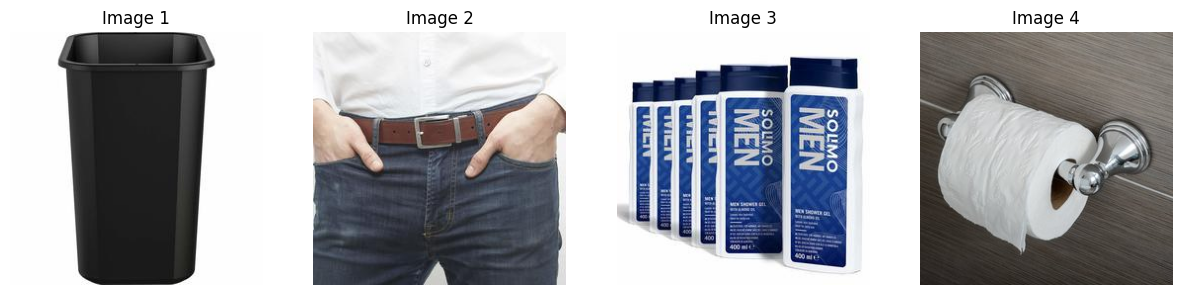

In [89]:
search_eng("MAN", 4)

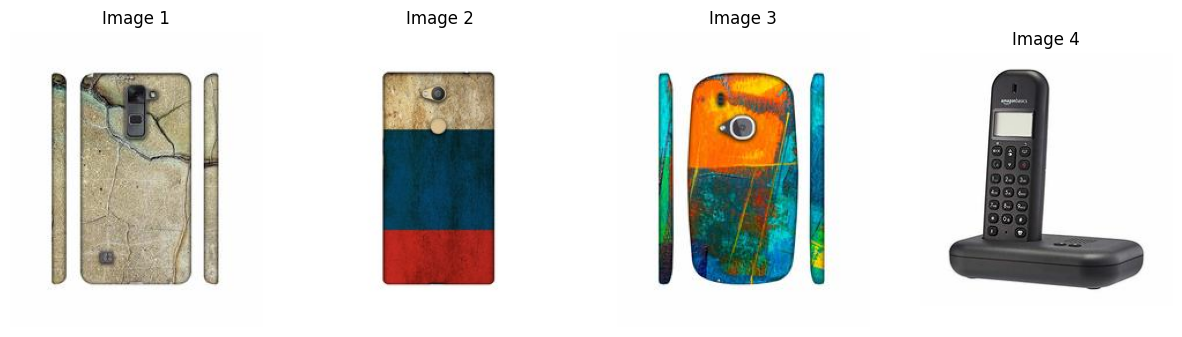

In [110]:
search_eng("old phone", 4)

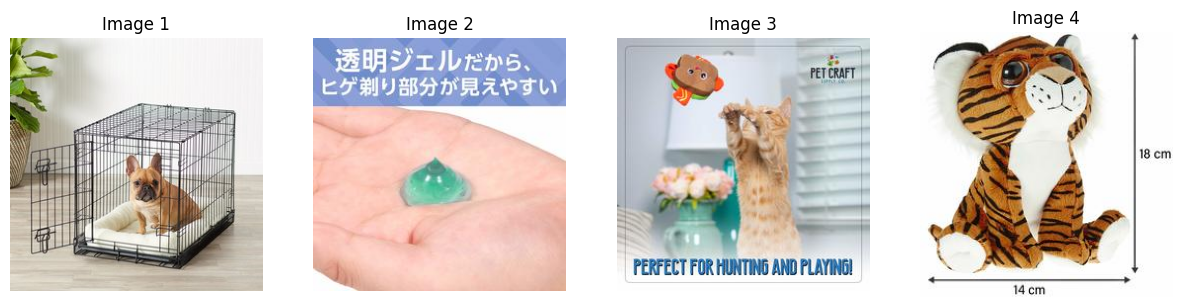

In [105]:
search_eng("Small pet", 4)

In [112]:
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)

NUM_IMAGES = 30000

image_paths = pl.Series(valid_paths_list).sample(NUM_IMAGES).to_list()
vectorize_images(engine, model, image_paths)

  0%|          | 0/30000 [00:00<?, ?it/s]

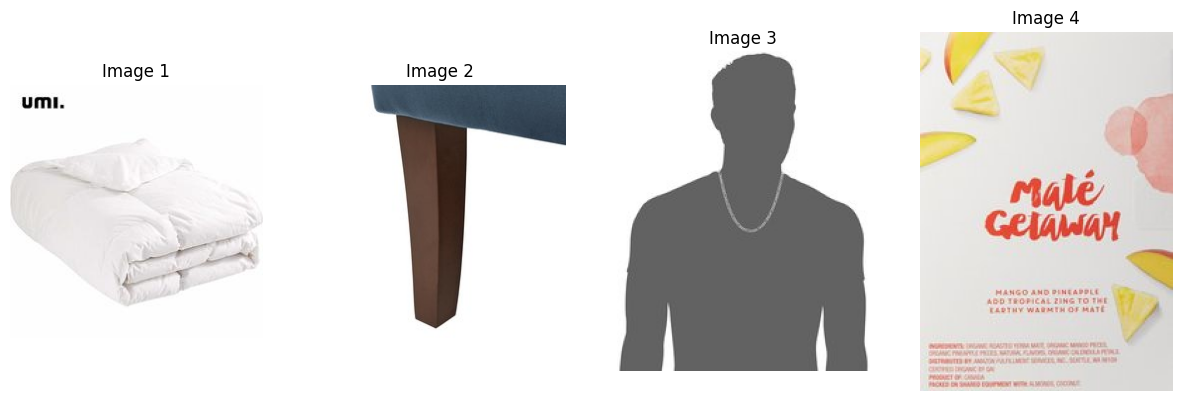

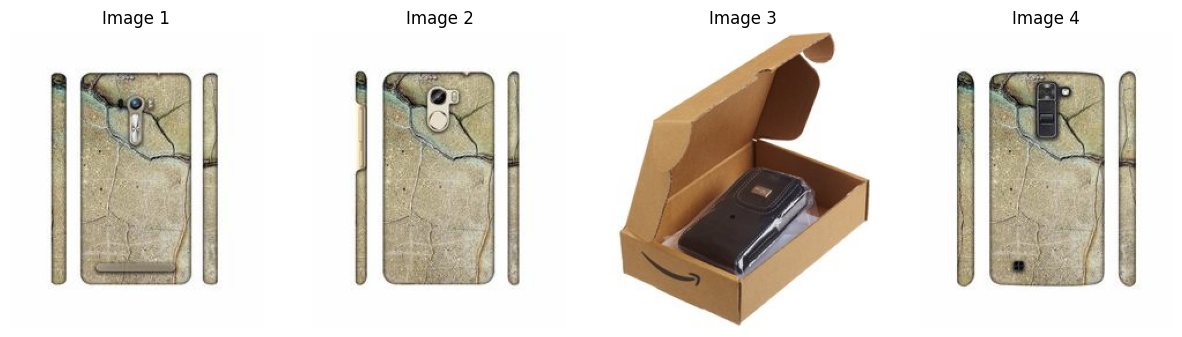

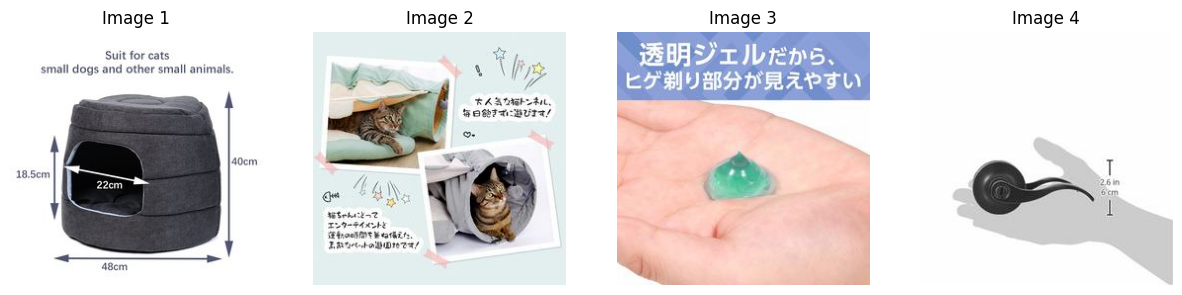

In [113]:
ImageSearch(engine, model)("MAN", 4)
ImageSearch(engine, model)("old phone", 4)
ImageSearch(engine, model)("small pet", 4)

In [114]:
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)

NUM_IMAGES = 5000

image_paths = pl.Series(valid_paths_list).sample(NUM_IMAGES).to_list()
vectorize_images(engine, model, image_paths)

  0%|          | 0/30000 [00:00<?, ?it/s]

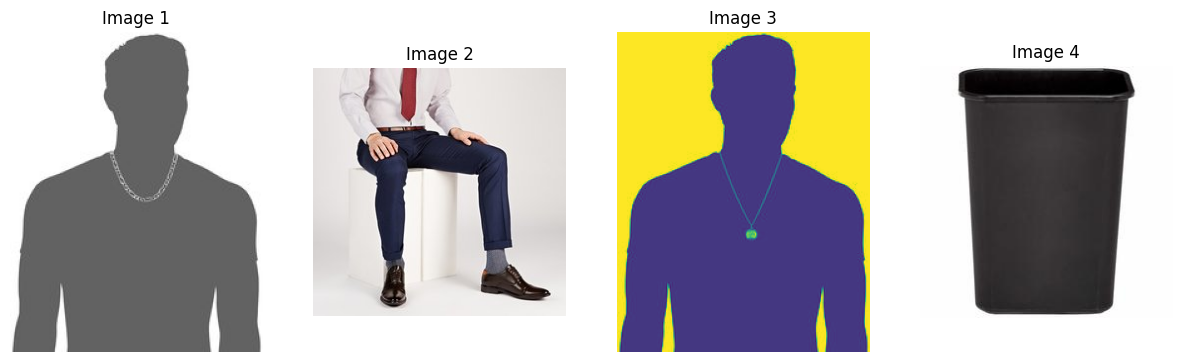

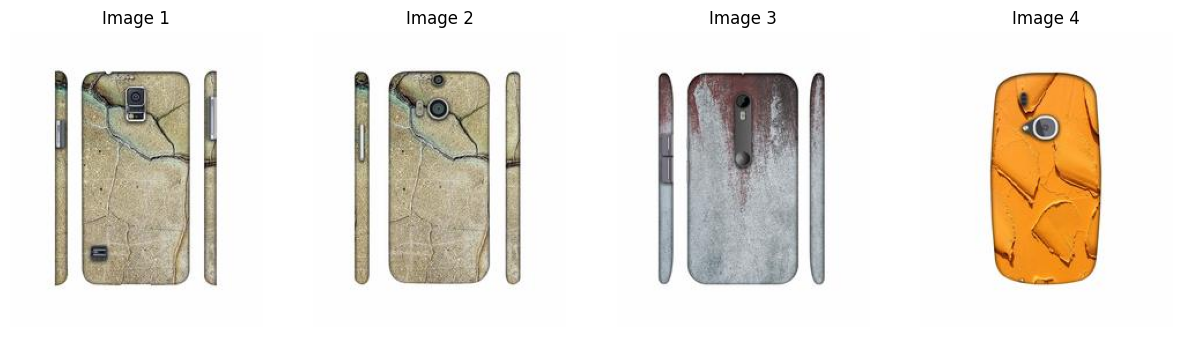

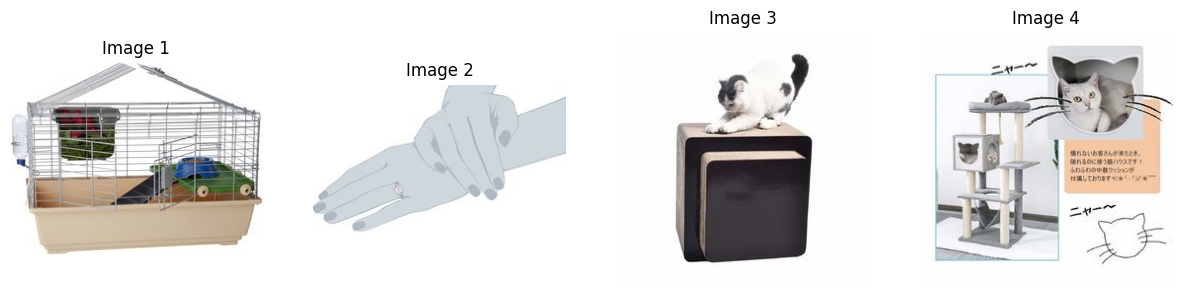

In [115]:
ImageSearch(engine, model)("MAN", 4)
ImageSearch(engine, model)("old phone", 4)
ImageSearch(engine, model)("small pet", 4)